## 7 - Vintage style
>Map something modern in a vintage aesthetic. Create a map that captures the look and feel of historical cartography but focuses on a contemporary topic. Use muted colors, fonts, and classic elements. 🕰️🗺️

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely import Polygon, LineString
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as mticker
import shapely
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
# helpers
def text_along_path(text, curve, ax, **kwargs):
    '''
    plots `text` along the `curve` on axes (`ax`)
    `kwargs` passed to `ax.text()`
    
    curve is array of shape (n,2)
    doesn't do any checks.
    requires some fanangling to get spacing right
    '''
    if isinstance(curve, LineString):
        ls = curve
        _x, _y = ls.coords.xy
        curve = np.c_[_x, _y]
    
    text_length = len(text)

    text_points = ls.interpolate(np.linspace(0, 1, text_length),
                                 normalized=True)
    text_x = [p.x for p in text_points]
    text_y = [p.y for p in text_points]

    dydx = np.gradient(curve[:,1], curve[:,0])
    angles = np.degrees(np.arctan(np.interp(text_x, curve[:,0], dydx)))

    for x, y, angle, t in zip(text_x, text_y, angles, text):
        ax.text(x, y, t, rotation=angle, rotation_mode='anchor', **kwargs)
        
def plot_line(ax, geom, **kwargs):
    ax.plot(*geom.coords.xy, **kwargs)
    
def plot_poly(ax, geom, **kwargs):
    ax.plot(*geom.exterior.coords.xy, **kwargs)
    
def plot_mutlipoly(ax, geom, **kwargs):
    [plot_poly(ax, g, **kwargs) for g in geom.geoms]
    
def plot_feature(ax, geom, **kwargs):
    if geom.geom_type == 'Polygon':
        plot_poly(ax, geom, **kwargs)
    elif geom.geom_type == 'LineString':
        plot_line(ax, geom, **kwargs)
    elif geom.geom_type == 'MultiPolygon':
        plot_mutlipoly(ax, geom, **kwargs)
    elif geom.geom_type == 'Point':
        ax.scatter(geom.x, geom.y, **kwargs)


In [3]:
aoi = Polygon([
            [
              -0.009031432891447366,
              51.50903971928628
            ],
            [
              -0.009031432891447366,
              51.49813331878647
            ],
            [
              0.022301445700378508,
              51.49813331878647
            ],
            [
              0.022301445700378508,
              51.50903971928628
            ],
            [
              -0.009031432891447366,
              51.50903971928628
            ]
          ])

In [4]:
prj = ccrs.epsg(27700)
minx, miny, maxx, maxy = gpd.GeoSeries([aoi], crs=4326).to_crs(prj).total_bounds
features = ox.features_from_polygon(aoi,
                                    tags={'water':True,
                                          'natural': True,
                                          'lock':True,
                                          'building':True,
                                          'man_made':['pier', 'bridge', 'lighthouse'],
                                          'bridge':True,
                                          'leisure':'marina',
                                          'highway':'construction',
                                          'aerialway':'gondola',
                                          'name': ['Compass', 'Here', 'Prime Meridian']                                          
                                          }
                                    ).to_crs(prj)

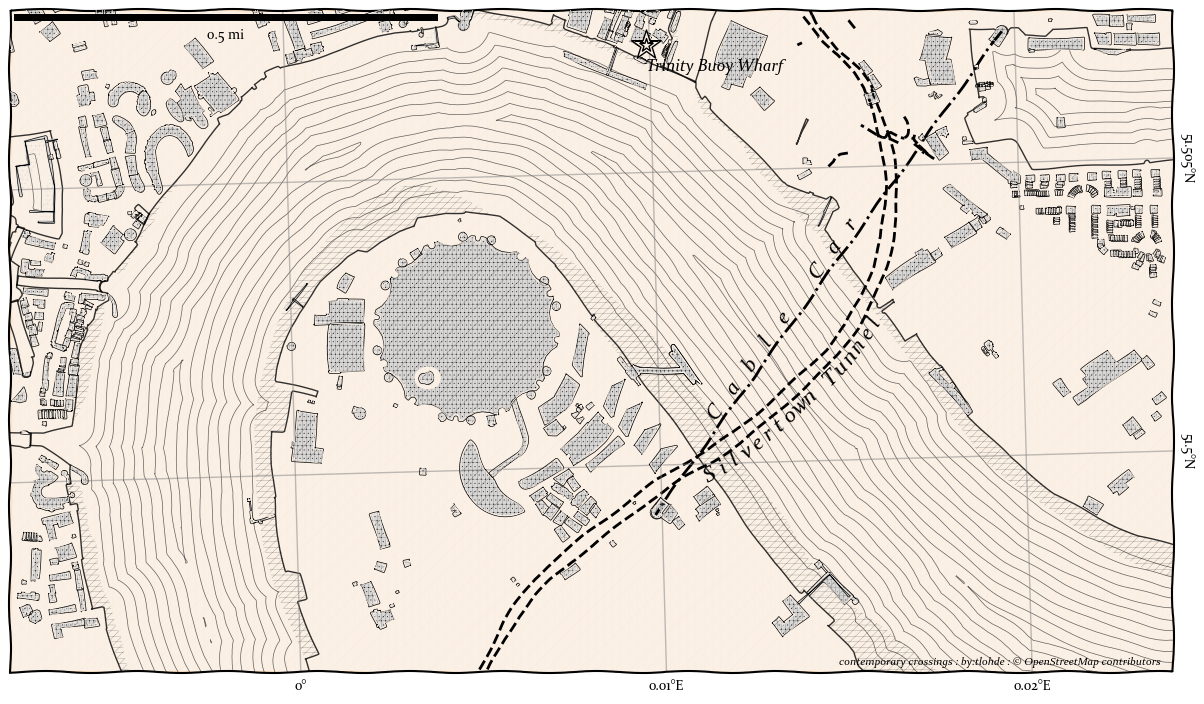

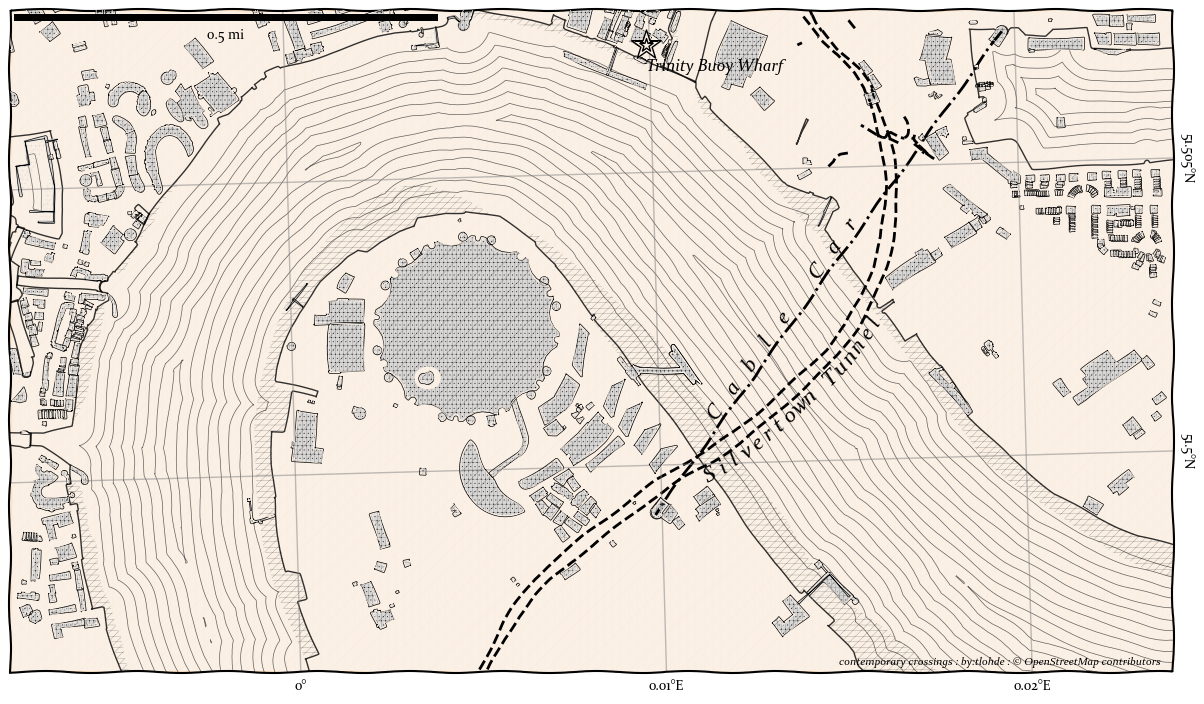

In [175]:
plt.rcParams['hatch.linewidth'] = 0.1
spacing = 20
maxb = 500

# for wiggly lines use xkcd context
with plt.xkcd():
    plt.rcParams['path.effects'] = [] # override xkcd's white path effects
    plt.rcParams['font.family'] = ['Constantia', 'serif']

    fig, ax = plt.subplots(figsize=[15,15], subplot_kw={'projection':prj})

    # hatch fill background
    ax.add_patch(Rectangle((minx, miny),
                            maxx-minx, maxy-miny,
                            fill=False,
                            hatch='||//',
                            color='bisque'))

    # water
    for f in features.loc[(features['natural']=='water')].itertuples():        
        plot_feature(ax, f.geometry, c='k', lw=1, zorder=1, alpha=0.8)
        if shapely.get_num_interior_rings(f.geometry) > 0:
            geom = Polygon(f.geometry.exterior)
        else:
            geom = f.geometry
        
        # plot interior buffers of water
        for b in np.arange(maxb+spacing, spacing, -spacing):
            buff = geom.buffer(-b)
            if buff.is_empty:
                continue
            else:
                plot_feature(ax, buff, color='k', lw=0.5, zorder=1, alpha=0.6)
                
    # wetlands
    features.loc[features['natural']=='wetland'].plot(ax=ax,
                                                        fc='none',
                                                        linewidth=0,
                                                        hatch='////---')
                
    ## buildings
    features.loc[(~features['building'].isna())
                #  | (features['man_made']=='bridge')
                | (features['man_made']=='pier')].plot(ax=ax,
                                                            color='lightgray',
                                                            alpha=0.85,
                                                            hatch='....//--||||',
                                                            zorder=2) 
    # building outlines (buffer'd internally in same color as background
    # and externally in same color as fill to try and 
    # make it look like it has been drawn
    for f in features.loc[(~features['building'].isna())
                        #   | (features['man_made']=='bridge')
                        | (features['man_made']=='pier')].itertuples():
        plot_feature(ax,
                        f.geometry.buffer(1),
                        lw=0.5,
                        zorder=3,
                        color='k')
        plot_feature(ax,
                        f.geometry.buffer(-1),
                        lw=0.5,
                        zorder=3,
                        color='linen')

    # lighthouse  
    for s in [500,100]:
        features.loc[features['man_made']=='lighthouse'].centroid.plot(ax=ax,
                                                                    marker='*',
                                                                    c='linen',
                                                                    ec='k',
                                                                    linewidth=1,
                                                                    markersize=s,
                                                                    zorder=4)

    _x, _y = features.loc[features['man_made']=='lighthouse'].centroid.iloc[0].coords.xy
    ax.annotate('Trinity Buoy Wharf',
                xy=(_x[0], _y[0]),
                xytext=(_x[0], _y[0]-50),
                fontstyle='italic', fontsize=12,
                )

    # silvertown tunnel
    for f in features.loc[features['highway']=='construction'].itertuples():
        plot_feature(ax, f.geometry, ls='--', c='k')
        if f.Index[1] == 1096402450:
            geom = f.geometry
            text_along_path('Silvertown Tunnel',
                            LineString(
                                [f.geometry.interpolate(i, normalized=True)
                                for i in np.arange(0.6, 0.3, -0.01)]),
                            ax=ax,
                            fontsize=16,
                            fontstyle='italic',
                            ha='center',
                            va='top')
    _, miny, _, maxy = features.loc[features['highway']=='construction'].total_bounds
        
    # cable car
    for f in features.loc[features['aerialway']=='gondola'].itertuples():
        plot_feature(ax, f.geometry, ls='-.', c='k')
        text_along_path('Cable Car',
                        LineString(
                            [f.geometry.interpolate(i, normalized=True)
                            for i in np.arange(0.8, 0.4, -0.01)]),
                        ax=ax,
                        fontsize=16, fontstyle='italic',
                        ha='center', va='bottom')
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5,)
    gl.xlocator = mticker.FixedLocator([0, 0.01, 0.02])
    gl.ylocator = LatitudeLocator(nbins=3)
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.top_labels = False
    gl.left_labels = False
    gl.rotate_labels = False
    gl.ylabel_style = {'rotation':-90}

            
    # axes limits
    ax.set(xlim=(minx, maxx),
            ylim=(miny, maxy))


ax.add_artist(ScaleBar(0.0006213712,
                        units='mi',
                        dimension='imperial-length',
                        location='upper left',
                        # length_fraction=0.8,
                        fixed_value=0.5,
                        box_alpha=0))

ax.annotate('contemporary crossings : by:tlohde : © OpenStreetMap contributors',
            xy=(0.99, 0.01),
            xycoords='axes fraction',
            ha='right',
            fontsize=8,
            fontstyle='italic')


ax.set_facecolor('linen')


In [176]:
fig.savefig('day7.png', dpi=300, bbox_inches='tight')